### Loading Packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image

from os import listdir
from glob import glob
from skimage.io import imread

import time
import copy
from tqdm import tqdm_notebook as tqdm

# Exploratory Data Analysis

In [7]:
files = listdir("/kaggle/input/breast-histopathology-images")
print(len(files))

280


Each file represents a patient and has 2 more folders each with images in them. The name of each file represents the patient id number.

In [8]:
base_path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

### Finding total number of images
Each patient id folder contains two folder 0 and 1. C indicates the class where 0 is non-IDC and 1 is IDC

In [9]:
total_images = 0 
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0,1]:
        patient_path = base_path + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [10]:
total_images

277524

### Storing patient_id, image path and target

In [11]:
# creating the dataframe
df = pd.DataFrame(index=np.arange(0,total_images), columns = ["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id
    for c in ['0','1']:
        class_path = patient_path + "/" + c + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            df.loc[k, "path"] = class_path + image_path
            df.loc[k, "target"] = int(c)
            df.loc[k, "patient_id"] = patient_id
            k += 1
            
df.head()

patient_id                                               path target
0      10295  ../input/breast-histopathology-images/IDC_regu...      0
1      10295  ../input/breast-histopathology-images/IDC_regu...      0
2      10295  ../input/breast-histopathology-images/IDC_regu...      0
3      10295  ../input/breast-histopathology-images/IDC_regu...      0
4      10295  ../input/breast-histopathology-images/IDC_regu...      0

In [12]:
df.shape

(277524, 3)

In [13]:
# value_counts -> number of 0s and 1s; size -> total number of images
cancer_plot = df.groupby("patient_id").target.value_counts() / df.groupby("patient_id").target.size()
cancer_plot = cancer_plot.unstack()
# The .unstack() method reshapes the resulting series into a DataFrame where the target values (0 and 1) become column headers. 

cancer_plot.head()

target             0         1
patient_id                    
10253       0.872495  0.127505
10254       0.910377  0.089623
10255       0.665441  0.334559
10256       0.750000  0.250000
10257       0.672441  0.327559

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


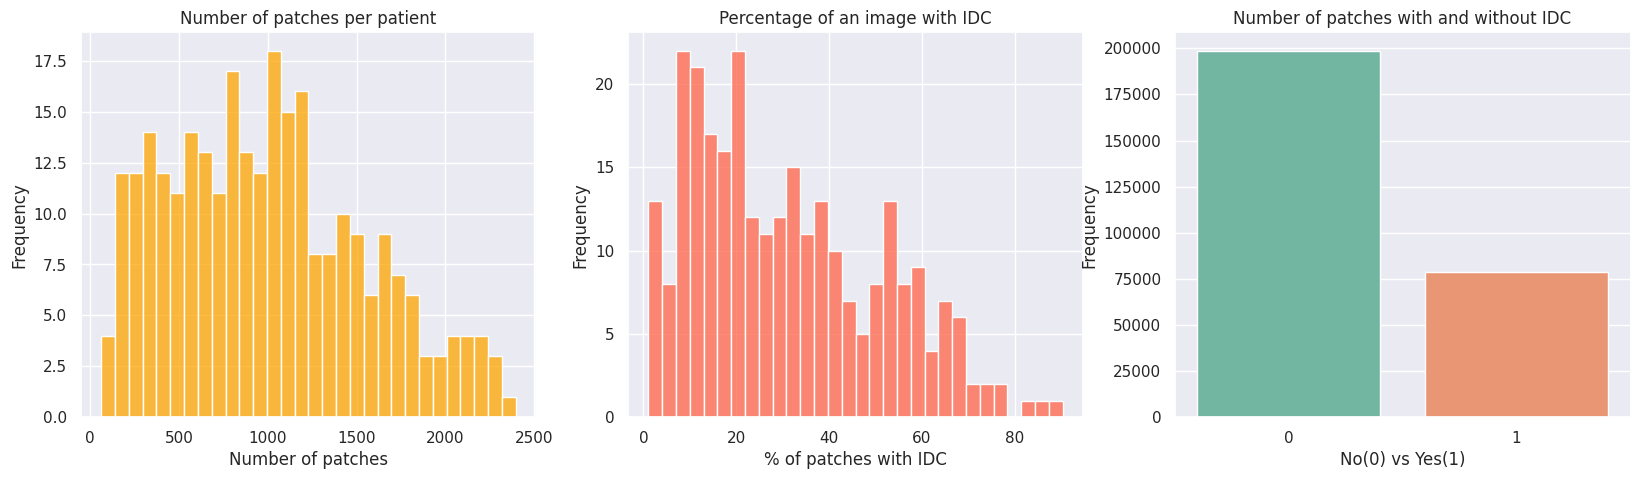

In [14]:
# plotting
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.histplot(df.groupby("patient_id").size(), ax=ax[0], color='Orange', kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Number of patches per patient")

sns.histplot(cancer_plot.loc[:,1]*100, ax=ax[1], color='Tomato', kde=False, bins=30)
ax[1].set_xlabel("% of patches with IDC")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Percentage of an image with IDC")

sns.countplot(x='target', data=df, palette='Set2', ax=ax[2])
ax[2].set_xlabel("No(0) vs Yes(1)")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Number of patches with and without IDC")

plt.show()

#### **Notes:**
1. The number of image patches per patient varies a lot! This leads to the questions **whether all images show the same resolution of tissue cells of if this varies between patients.**
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. **Does a tissue slice per patient cover the whole region of interest?**
3. **The classes of IDC versus no IDC are imbalanced.** We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

## Visualizing healthy and cancerous patches

In [15]:
df.target = df.target.astype(int)

In [16]:
pos_idc = np.random.choice(df[df.target == 1].index.values, size=50, replace=False)
neg_idc = np.random.choice(df[df.target == 0].index.values, size=50, replace=False)

### Cancer Patches

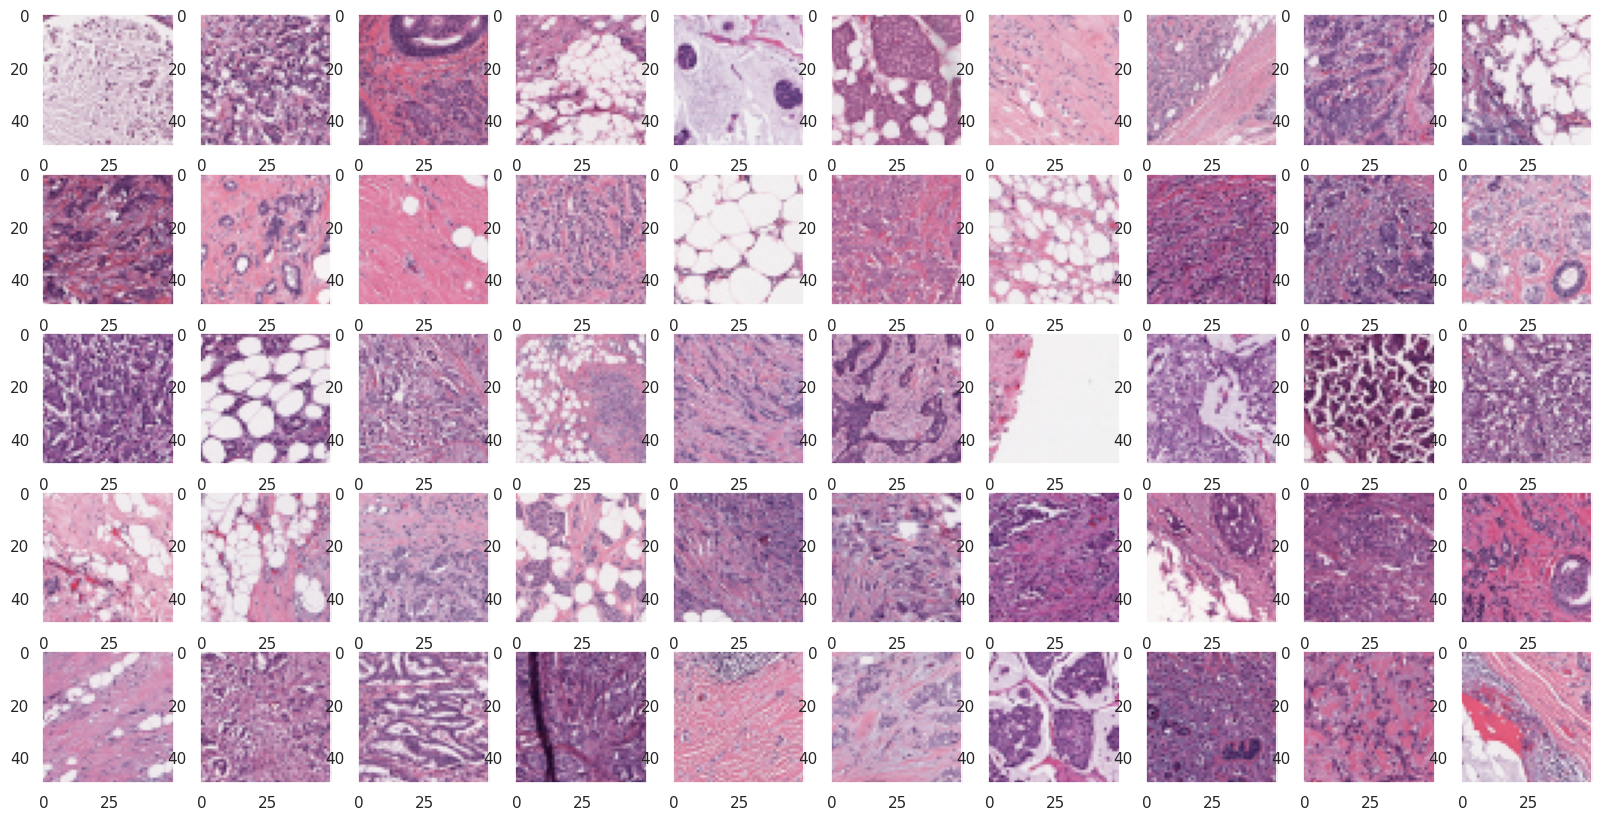

In [17]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_idc[m + 10*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy patches

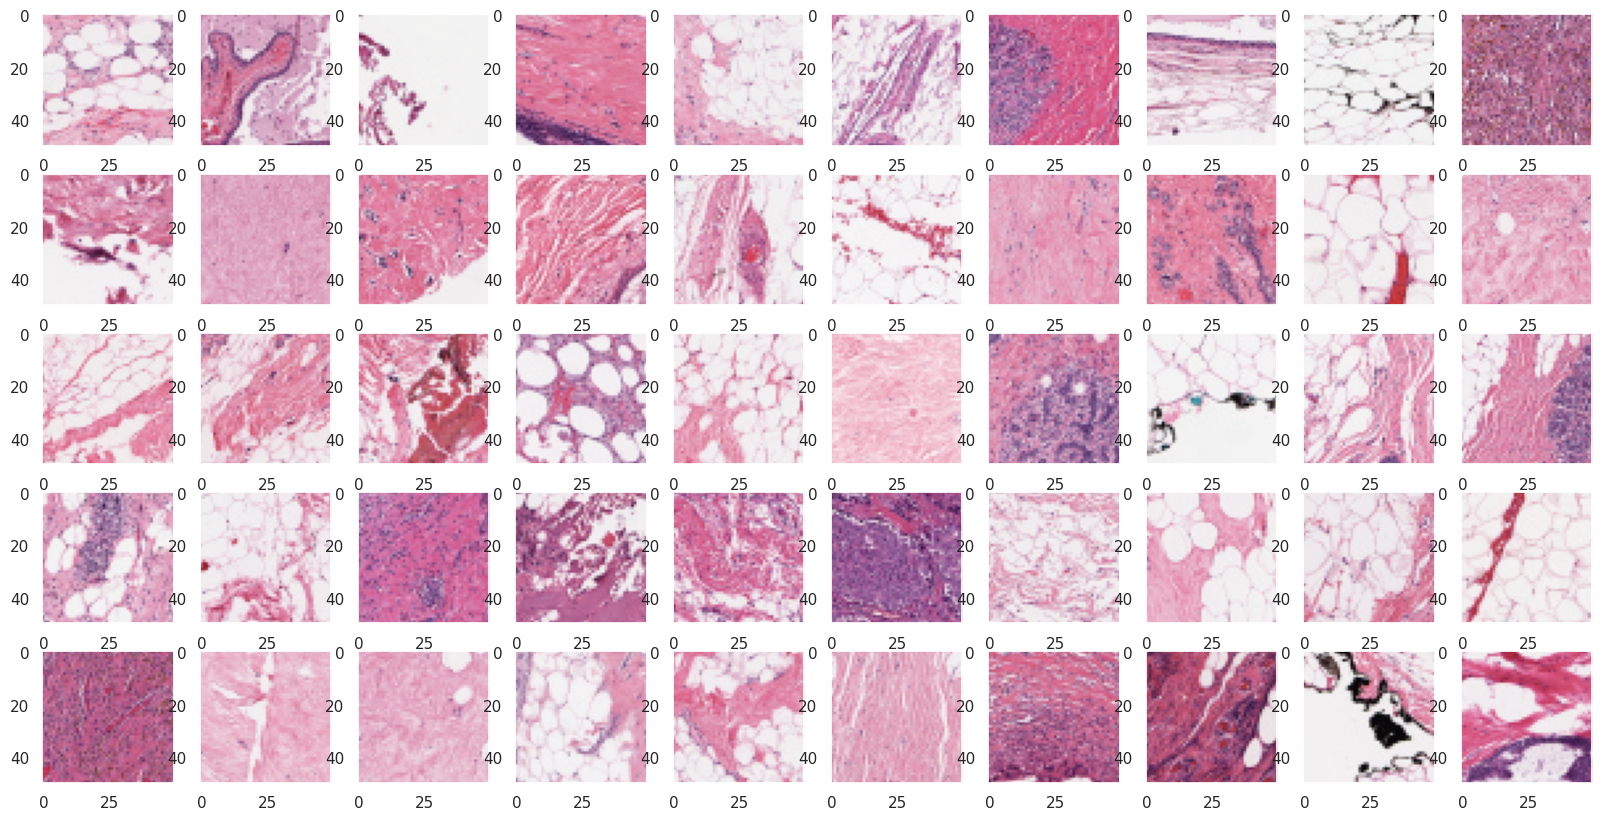

In [18]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_idc[m + 10*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

## Reconstructing the breast tissue
This task involves a complex procedure that necessitates the extraction of coordinates from the names of image patches. These coordinates are crucial for the reconstruction of the entire breast tissue for a given patient. Through this reconstruction process, it becomes feasible to conduct a comparative analysis between diseased and healthy tissues. To simplify this task a method that takes a patient and outcomes a dataframe with coordinates and targets is written.

In [19]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [20]:
example = get_patient_dataframe(df.patient_id.values[0])
example.head()

x     y  target                                               path
0  1351  1101       0  ../input/breast-histopathology-images/IDC_regu...
1  1501   501       0  ../input/breast-histopathology-images/IDC_regu...
2  1501  1101       0  ../input/breast-histopathology-images/IDC_regu...
3   451   901       0  ../input/breast-histopathology-images/IDC_regu...
4   801   451       0  ../input/breast-histopathology-images/IDC_regu...

In [21]:
# # df.patient_id.values[0]
# path = base_path + df.patient_id.values[0] + "/" + "0" #no cancer
# # path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0"

# files = listdir(path)
# # len(files) = 761 
# # files ex: '10295_idx5_x1351_y1101_class0.png' => filename in new dataframe

# dataframe = pd.DataFrame(files, columns=["filename"]) #creating df with 1 col = filename for class 0 of patient id 10295
# # dataframe
# path_names = path + "/" + dataframe.filename.values
# # path_names => array of concatentaed paths; ex: '../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png'

# dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
# # 10295_idx5_x1351_y1101_class0.png => 10295 idx x1351 y1101 class0.png => 4 splits at _

# dataframe.loc[:, "target"] = int("0") # cancer id = 0; add target col to dataframe
# dataframe.loc[:, "path"] = path_names # add path col to dataframe
# """
# 	0	     1	      2	      3	      4	        target	path
# 0	10295	idx5	x1351	y1101	class0.png	0	../input/breast-histopathology-images/IDC_regu...
# """

# dataframe = dataframe.drop([0,1,4], axis=1) # drop patient_id, idx5 and class0.png col
# dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1) # rename 2 to x and 3 to y
# dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int) #convert coordinate values to int
# dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)

# dataframe # now df only contains x,y target and path
# """
#      x	     y	    target	path
# 0	1351	1101	0	../input/breast-histopathology-images/IDC_regu...
# 1	1501	501	0	../input/breast-histopathology-images/IDC_regu...
# """

### Binary target visualisation per tissue slice

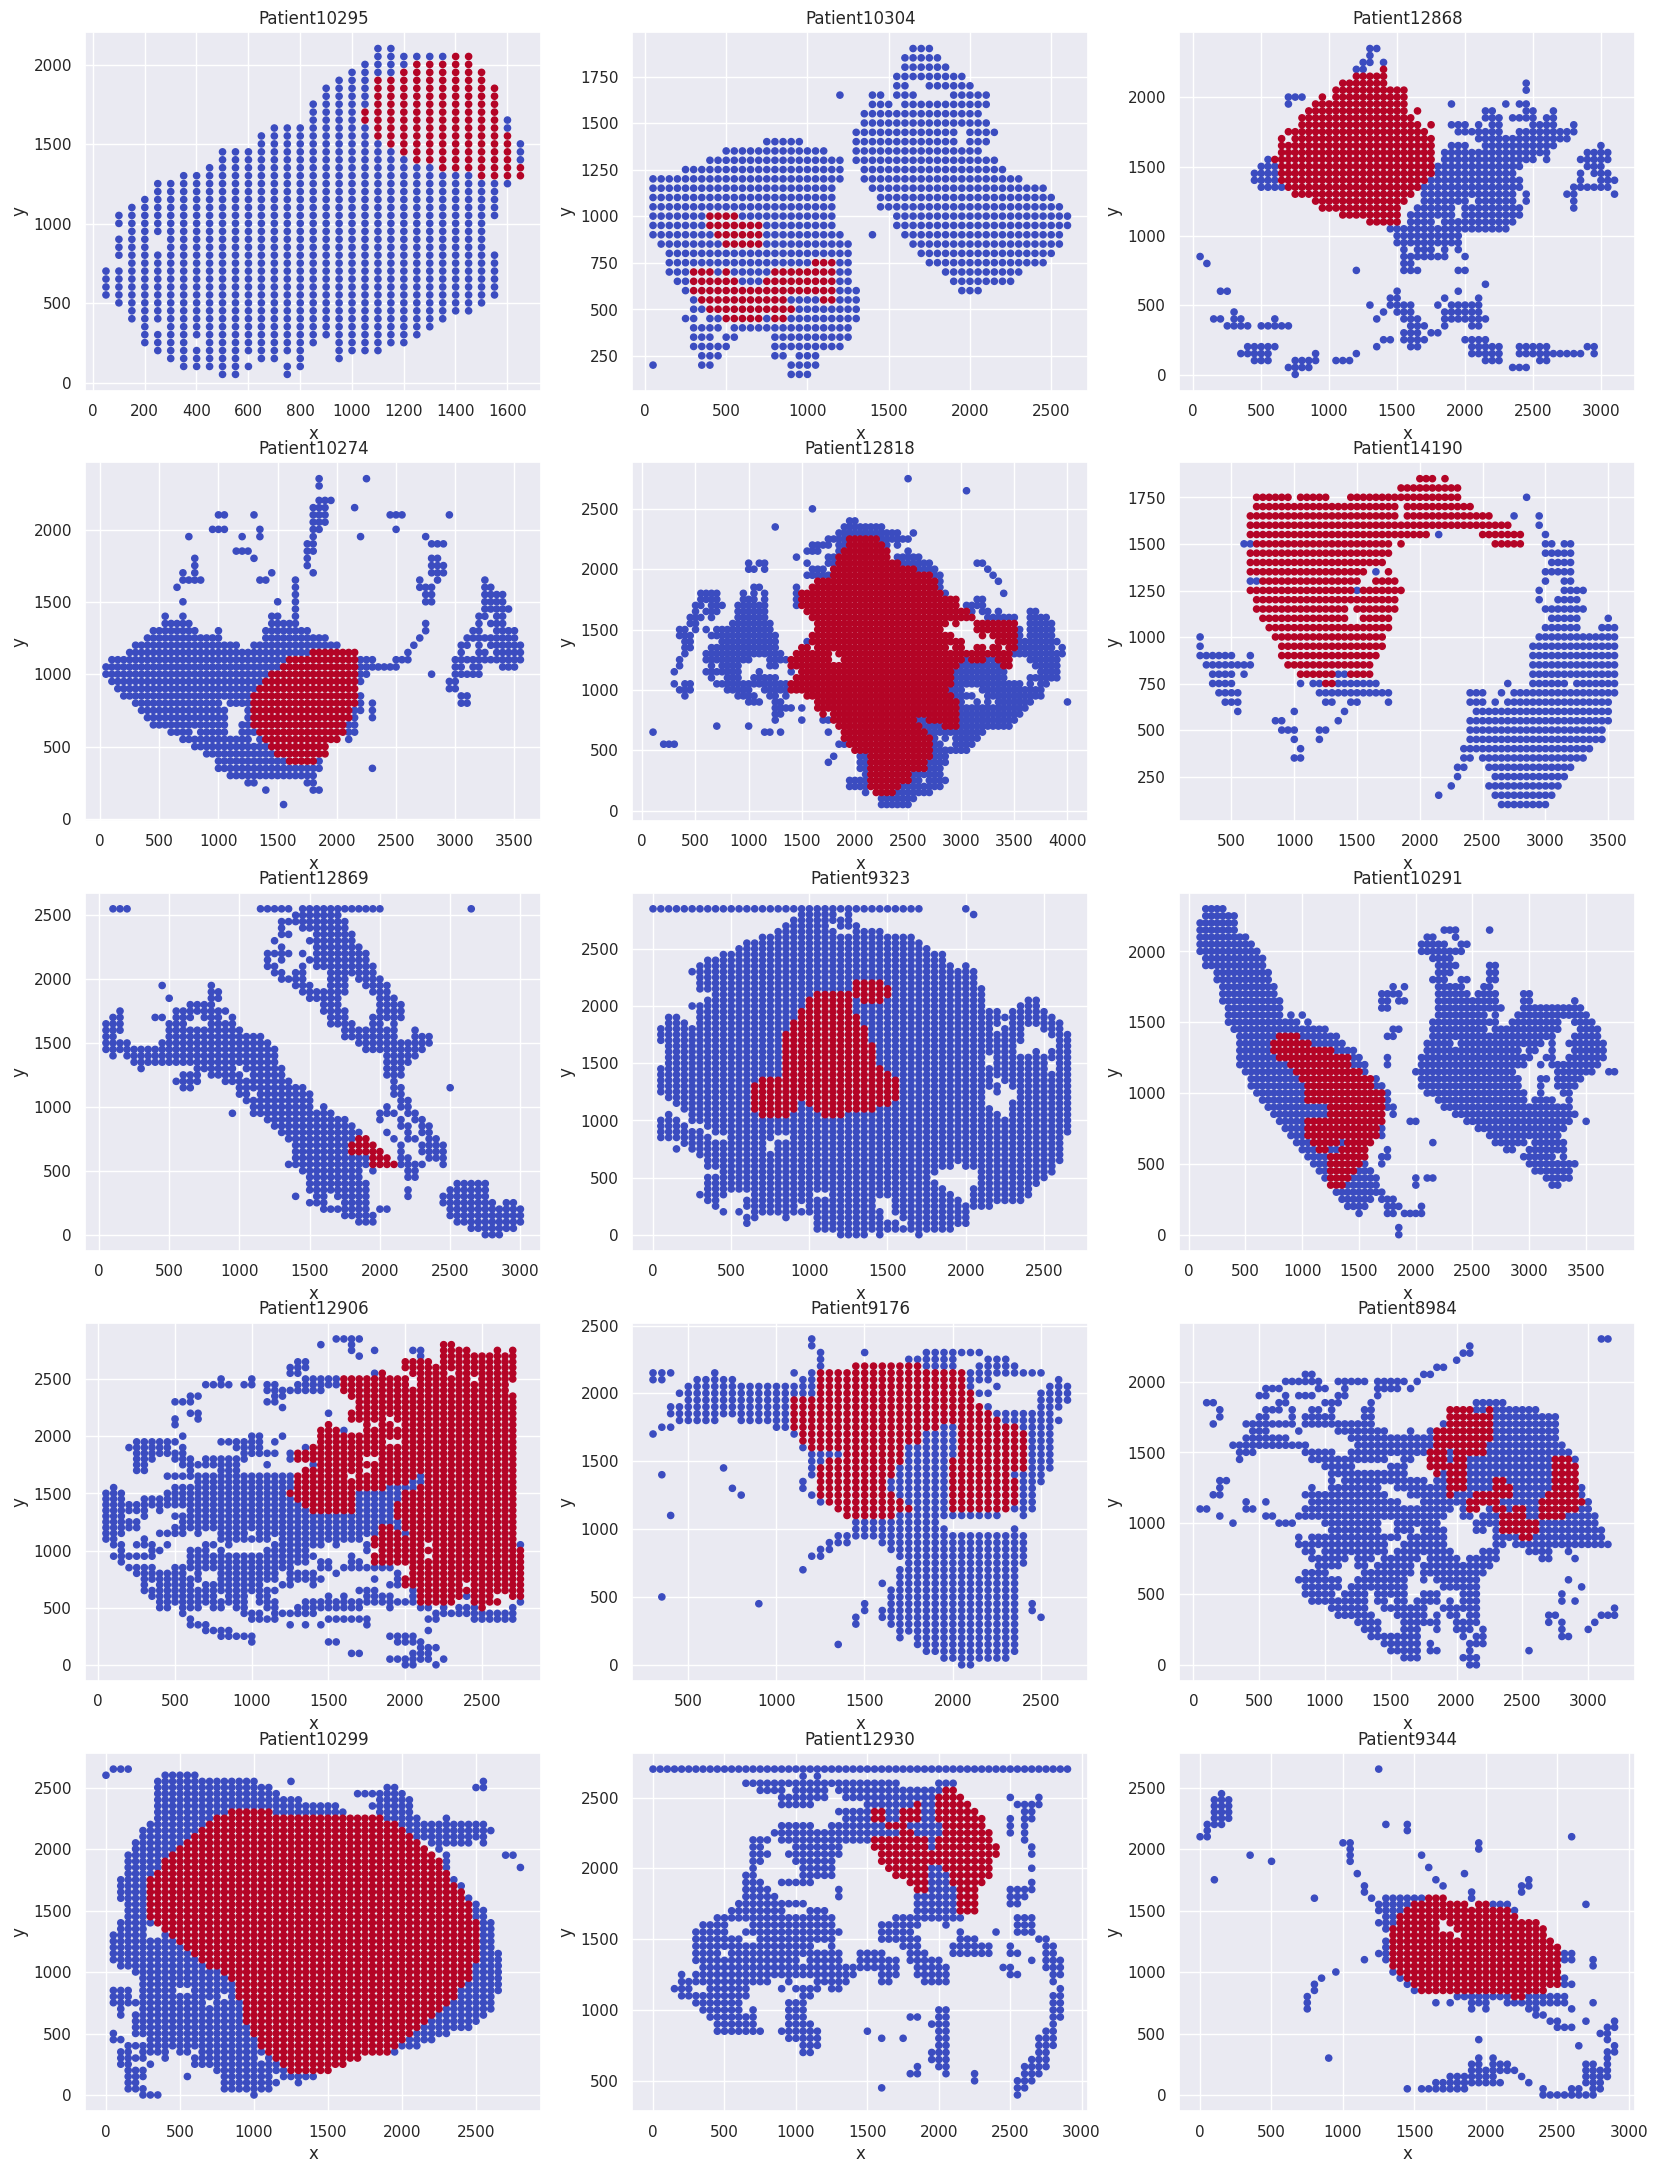

In [22]:
fig, ax = plt.subplots(5,3,  figsize = (20,27))

patient_ids = df.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m+3*n]
        patient_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(patient_df.x.values, patient_df.y.values, c=patient_df.target.values, cmap="coolwarm", s=20)
        ax[n,m].set_title("Patient" + patient_id)
        ax[n,m].set_xlabel("x")
        ax[n,m].set_ylabel("y")
        
# red => cancer present in those coordinates
# blue => no cancer in those coordinates

In [23]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

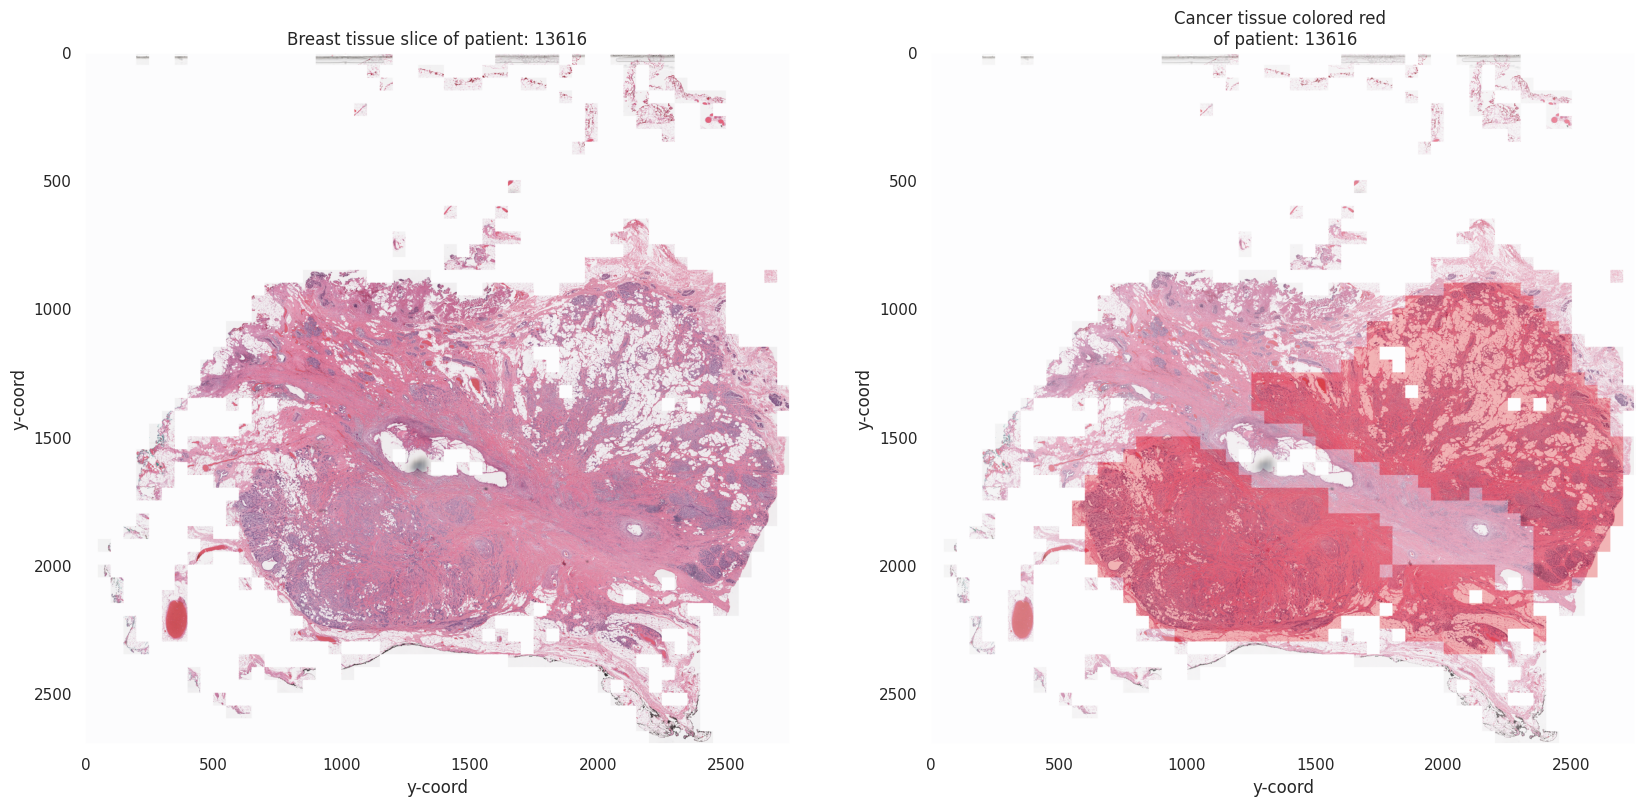

In [24]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + example)
ax[1].set_title("Cancer tissue colored red \n of patient: " + example);

In [25]:
df.head()

patient_id                                               path  target
0      10295  ../input/breast-histopathology-images/IDC_regu...       0
1      10295  ../input/breast-histopathology-images/IDC_regu...       0
2      10295  ../input/breast-histopathology-images/IDC_regu...       0
3      10295  ../input/breast-histopathology-images/IDC_regu...       0
4      10295  ../input/breast-histopathology-images/IDC_regu...       0

### Insights
* The tissue on the left is shown without target information.
* The image on the right shows the same tissue but cancer is stained with intensive red color.
* Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color.
* But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer!

# Setting up workflow for ML Model

### Validation Strategy
* 30% -> test data
* 70% -> training and developing data

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df.head()
df["target"] = df["target"].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


In [28]:
import cv2

In [39]:
# Split data into train+val and test sets
# Randomly select 30,000 images
sampled_df = df.sample(n=60000, random_state=42)  # Change n if your df has fewer than 30,000 rows

train_val, test = train_test_split(sampled_df, test_size=0.15, random_state=42)

# Split train+val into train and validation sets
train, val = train_test_split(train_val, test_size=0.1765, random_state=42)  
# 0.1765 is approximately 15% when taken out of 85%


In [40]:
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

Train set size: 41998
Validation set size: 9002
Test set size: 9000


In [41]:
train.to_csv('train_dataset.csv', index=False)
val.to_csv('validation_dataset.csv', index=False)
test.to_csv('test_dataset.csv', index=False)

In [42]:
# Create ImageDataGenerators for training and testing/validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators from DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='target',
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary'
)

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='path',
    y_col='target',
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='target',
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary'
)

Found 41998 validated image filenames belonging to 2 classes.
Found 9002 validated image filenames belonging to 2 classes.
Found 9000 validated image filenames belonging to 2 classes.


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Flatten(),
    
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(24, activation='relu'),
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
batch_size = 32
history = model.fit(
    train_generator,
    steps_per_epoch=len(train) // batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=len(val) // batch_size
)

Epoch 1/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 127s 88ms/step - accuracy: 0.8209 - loss: 0.4114 - val_accuracy: 0.7776 - val_loss: 0.5141
Epoch 2/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step - accuracy: 0.8438 - loss: 0.2971 - val_accuracy: 0.9000 - val_loss: 0.2420
Epoch 3/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 108s 82ms/step - accuracy: 0.8438 - loss: 0.3630 - val_accuracy: 0.8500 - val_loss: 0.3468
Epoch 4/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.7500 - loss: 0.3564 - val_accuracy: 0.9000 - val_loss: 0.2513
Epoch 5/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 107s 81ms/step - accuracy: 0.8425 - loss: 0.3548 - val_accuracy: 0.7403 - val_loss: 1.0166
Epoch 6/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.8125 - loss: 0.3137 - val_accuracy: 0.8000 - val_loss: 0.9121
Epoch 7/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 108s 82ms/step - accuracy: 0.8484 - loss: 0.3503 - val_accuracy: 0.7608 - val_loss: 0.4945
Epoch 8/40
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.8750 

In [48]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(test_generator)

# Make predictions on new data
predictions = model.predict(test_generator)

282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.8264 - loss: 0.5278
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step


In [ ]:
pos_idc_imgs = []
neg_idc_imgs = []

for index, row in df.iterrows():
    # Read the image
    img = cv2.imread(row['path'], cv2.IMREAD_COLOR)
    img_size = cv2.resize(img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Append the image to the appropriate list based on the target value
    if row['target'] == '1':
        pos_idc_imgs.append([img_size,1])
    else:
        neg_idc_imgs.append([img_size,0])
    

In [ ]:
print(len(pos_idc_imgs))
print(len(neg_idc_imgs))

In [ ]:
import random
X = []
y = []
total_imgs = pos_idc_imgs + neg_idc_imgs
random.shuffle(total_imgs)
total_imgs = total_imgs
for img_arr, target in total_imgs:
    X.append(img_arr)
    y.append(target)


X = np.array(X)
y = np.array(y)

In [ ]:
num_y_equals_1 = np.sum(y == 1)
num_y_equals_0 = np.sum(y == 0)

print("Number of images with y == 1:", num_y_equals_1)
print("Number of images with y == 0:", num_y_equals_0)

In [ ]:
# training, validation and testing data

# First split: Separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Note: By specifying test_size=0.25 in the second split, we're effectively keeping 60% of the data for training,
# 20% for validation, and 20% for testing, since the second split is applied to 80% of the original data.


In [ ]:
print(X_train.shape)
print(X_test.shape)

# Building the Model

In [ ]:
# importing necessary librabries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# model = models.Sequential([
#     layers.Input(shape=(50, 50, 3)),
#     layers.Conv2D(32, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
    
#     layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
    
#     layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.Flatten(),
    
#     layers.Dense(128),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
    
#     layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [ ]:
def train_model(X_train, y_train, X_val, y_val, dropout_prob, lr, batch_size, epochs):
    early_stop=EarlyStopping(monitor='val_loss',patience=5)
    model = Sequential([
      Input(shape=(50,50,3)),
      Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      MaxPooling2D((2, 2)),
      BatchNormalization(),
      Dropout(dropout_prob),
      Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      Dropout(dropout_prob),
      Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      Flatten(),
      Dense(128, activation='relu', kernel_initializer='he_uniform'),
      BatchNormalization(),
      Dense(64, activation='relu', kernel_initializer='he_uniform'),
      BatchNormalization(),
      Dense(64, activation='relu', kernel_initializer='he_uniform'),
      Dropout(dropout_prob),
      Dense(24, activation='relu', kernel_initializer='he_uniform'),
      Dense(1, activation='sigmoid'),
      
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0
    )

    return model, history

In [ ]:
# least_val_loss = float('inf')
# least_loss_model = None
# epochs=100
# for dropout_prob in[0, 0.2]:
#     for lr in [0.01, 0.005, 0.001]:
#         for batch_size in [32, 64, 128]:
#             print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
#             model, history = train_model(X_train, y_train, X_val, y_val, dropout_prob, lr, batch_size, epochs)
#             plot_history(history)
#             val_loss = model.evaluate(X_val, y_val)[0]
#             if val_loss < least_val_loss:
#                 least_val_loss = val_loss
#                 least_loss_model = model

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential([
  Input(shape=(50,50,3)),
  Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  BatchNormalization(),
  Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  MaxPooling2D((2, 2)),
  BatchNormalization(),
  Dropout(0.3),
  Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  BatchNormalization(),
  Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  Flatten(),
  Dense(128, activation='relu', kernel_initializer='he_uniform'),
  BatchNormalization(),
  Dense(64, activation='relu', kernel_initializer='he_uniform'),
  BatchNormalization(),
  Dense(64, activation='relu', kernel_initializer='he_uniform'),
  Dropout(0.3),
  Dense(24, activation='relu', kernel_initializer='he_uniform'),
  Dense(1, activation='sigmoid'),

])




In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train, epochs=40, batch_size=35, validation_data=(X_val, y_val),verbose=1
)

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# optimizer = Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model with early stopping
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, callbacks=[early_stopping])
